In [ ]:
%matplotlib notebook

# Imports
import random
import numpy as np
import itertools
import h5py
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from keras.utils.vis_utils import plot_model
from keras.losses import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution
sys.path.append('./libraries/Keras-HDF5-ImageDataGenerator/')
from h5imagegenerator.generator import HDF5ImageGenerator
from albumentations import Compose, Crop, ToFloat, Normalize
sys.path.append('./libraries/Deep----Koopman/')
from Architecture import _transformer, _pred_K, linear_update, compute_aux_inputs, JacobianLayer

#Initialise learning
%killbgscripts
import keras
from keras import backend as K
K.clear_session()
disable_eager_execution() # Needed for running custom loss
sns.set(font_scale=1)

#Fix the seed, for evaluation
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# B. Learning pendulum dynamics

In this notebook we follow on from the first tutorial (A. Pendulum dynamics outline) to explore learning the dynamics of a pendulum using a Koopman operator theory based deep learning approach. 

The examples here use the method created by [^fn1], and are run using a modified version of the Keras implementation from [^fn3]).

This notebook is primarily focused on presenting and analysing the spectral outputs (e.g. eigenfunctions) of the learnt model (the later sections of this notebook). To help elucidate these results, a modified implementation of [^fn3] is also included here. As the focus of this repository is on tutorials, technical/implementation details are secondary, and as such this code might not be able to run as is.

[^fn1]: Lusch, B., Kutz, J.N. & Brunton, S.L. Deep learning for universal linear embeddings of nonlinear dynamics. Nat Commun 9, 4950 (2018). https://doi.org/10.1038/s41467-018-07210-0

[^fn3]: https://github.com/dykuang/Deep----Koopman


# i) Creating the model

## Generate data

Firstly a dataset of pendulum swings should be generated. The notebook 'Generate pendulum data.ipynb' should be run, with the following control options:

- pendulum_type = 'rigid'
- control = False
- friction = 0

This will generate six datasets into the 'data' subdirectory:

- train/test/valid : Randomly generated trajectories of motion
- top/mid/bottom : Lengthy trajectories initialised at specific angles, to visualise different states

In [2]:
# Define the system to model
system = 'pendulum'  # Possible values: 'pendulum', 'quadratic'

In [3]:
if system == 'pendulum':
    system_behaviour = 'oscilatory'
elif system == 'quadratic':
    system_behaviour = 'convergent'

In [4]:
# Variables for learning
BATCH_SIZE = 128
EPOCHS = 100

## Load the datasets

This code uses a modified version of the Keras-HDF5-ImageDataGenerator, where modifications perform augmentations of the output.

This modification included in this repository's libraries folder, and is also avaliable at https://gitlab.com/Brendan_Michael/Keras-HDF5-ImageDataGenerator


In [5]:
xmax_state = 2  # Number of state variables
num_control = 0 # Number of control variables
DATA_TIMESTEPS = 50

# Trim any extra timesteps
augmentor = Compose([
    Crop(x_min=0,  x_max=xmax_state,y_min=0,y_max=DATA_TIMESTEPS),
])
augmenter_labels = Compose([
    Crop(x_min=0,  x_max=xmax_state,y_min=0,y_max=DATA_TIMESTEPS),
])

# Set keys
X_key = 'state_time'
y_key = 'state_time_plus_1'
classes_key = 'state_time_plus_1'

# Define generators on the HDF5 files
# By using generators, we don't need to load all samples into memory at once. Its a bit slower, but it means we can used many more samples
# Define a generator where input is state at t, and output is state at t+1
train_generator = HDF5ImageGenerator(
        src = './data/train.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False, # This assumes inputs are [0,255] (standard images), and shouldn't be used. Instead normalise as explict layer
        labels_encoding=False, # this is fine, as its regression
        batch_size=BATCH_SIZE,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, # also crop the outputs
        shuffle=True,
)

valid_generator = HDF5ImageGenerator(
        src='./data/valid.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False,
        labels_encoding=False,
        batch_size=BATCH_SIZE,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, 
        shuffle=True,
)

test_generator = HDF5ImageGenerator(
        src='./data/test.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False,
        labels_encoding=False,
        batch_size=BATCH_SIZE,
        mode='train', 
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, 
        shuffle=True,
)

EVALUATION_INTERVAL = len(train_generator._indices) // BATCH_SIZE
VALIDATION_STEPS = len(valid_generator._indices) // BATCH_SIZE


# Define generators for the long term data. This is used to compare against predictions made far into the future, and are not used for training.
NUM_DELAYS = 969

long_generator_a = HDF5ImageGenerator(
        src = './data/long_a.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False, # This assumes inputs are [0,255] (standard images), and shouldn't be used. Instead normalise as explict layer
        labels_encoding=False, # this is fine, as its regression
        batch_size=NUM_DELAYS,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, # also crop the outputs
        shuffle=True,
)

long_generator_b = HDF5ImageGenerator(
        src = './data/long_b.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False, # This assumes inputs are [0,255] (standard images), and shouldn't be used. Instead normalise as explict layer
        labels_encoding=False, # this is fine, as its regression
        batch_size=NUM_DELAYS,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, # also crop the outputs
        shuffle=True,
)

long_generator_c = HDF5ImageGenerator(
        src = './data/long_c.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False, # This assumes inputs are [0,255] (standard images), and shouldn't be used. Instead normalise as explict layer
        labels_encoding=False, # this is fine, as its regression
        batch_size=NUM_DELAYS,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, # also crop the outputs
        shuffle=True,
)


### If the datasets are small enough, load training data into memory instead of generators to speed up learning

In [6]:
load_into_memory = True

In [7]:
if load_into_memory:
    filename = './data/train.hdf5'
    with h5py.File(filename, "r") as f:        
        train_input = f[list(f.keys())[0]][()]  # returns as a numpy array
        train_output = f[list(f.keys())[1]][()]  # returns as a numpy array

    filename = './data/valid.hdf5'
    with h5py.File(filename, "r") as f:    
        valid_input = f[list(f.keys())[0]][()]  # returns as a numpy array
        valid_output = f[list(f.keys())[1]][()]  # returns as a numpy array

    train_input = train_input[:,:,:xmax_state]
    train_output = train_output[:,:,:xmax_state]
    valid_input = valid_input[:,:,:xmax_state]
    valid_output = valid_output[:,:,:xmax_state]


# Visualise trajectories

The goal of learning the pendulum dynamics, is to create a model that allows us to predict future states given current observations. For example, the below image shows sample trajectories, where both the historical data and state is avaliable. The goal is to use that data, to predict what the next state will be.

Text(0.5, 1.0, 'State space')

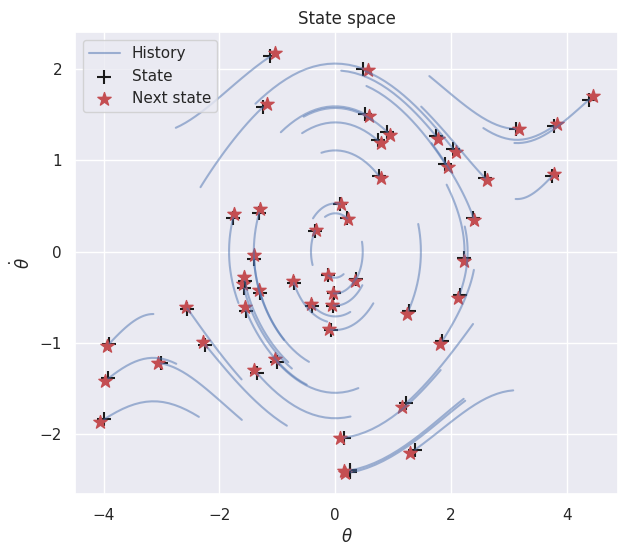

In [8]:
%matplotlib inline

fig = plt.figure(figsize=(7,6))
for i in range(50):
    plt.plot(train_generator[0][0][i,::3,0],train_generator[0][0][i,::3,1],color='b',alpha=0.5,label='History' if i==0 else '')
    plt.scatter(train_generator[0][1][i,-3,0],train_generator[0][1][i,-3,1],color='k',alpha=1,marker='+',s=100,label='State' if i==0 else '')
    plt.scatter(train_generator[0][1][i,-1,0],train_generator[0][1][i,-1,1],color='r',alpha=1,marker='*',s=100,label='Next state' if i==0 else '')
plt.legend(loc=2)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.title('State space')

## Parameterisation

Network parameters are defined according to the Deep Koopman paper

In [9]:
'''
Adapted from https://github.com/dykuang/Deep----Koopman
'''
par = {
       'input steps':DATA_TIMESTEPS,
       'latent steps':DATA_TIMESTEPS,
       'output steps':DATA_TIMESTEPS,
       'pred steps': DATA_TIMESTEPS,
       'batch size': BATCH_SIZE,
       'en dim list': [80,80], # widths of encoder (two layers)
       'de dim list': [80,80], # widths of deencoder (two layers)
       'K reg': 10e-14,
       'epochs': EPOCHS,
       'hidden_widths_omega': [170], # the width of the auxiliary network (one layer)
       'lr': 0.001, 
       'alpha_1' : 0.001, 
        #'alpha_2' : 10e-9, # this is an infinity norm term, but its not used in the code
       'alpha_3' : 10e-14,
        'gamma' : 0.001, # an norm term for controlling the Jacobian loss
       'dt' : 0.02
       }

if system == 'pendulum':
    par['num complex'] = 1  # number of conjugate pairs (only one is needed for pendulum)
    par['num real']    = 0    
elif system == 'quadratic':
    par['num complex'] = 0  
    par['num real']    = 2  # number of conjugate pairs (two real one is needed for quadtratic)
        
par['num_samples'], par['time steps'], par['input feature dim'] = train_generator[0][0].shape
par['num_samples'], par['time steps'], par['output feature dim'] = train_generator[0][1].shape
input_shape = (par['input steps'], par['input feature dim'])
output_shape = (par['input steps'], par['output feature dim'])

# Latent dimension
par['latent dim'] = 2*par['num complex'] + par['num real'] # Each complex number is a pair here, so number of dimensions = 2c+r
latent_shape = (par['latent steps'],)+ (par['latent dim'],)

# Define losses

In [10]:
'''
Adapted from https://github.com/dykuang/Deep----Koopman
Loss function is modified here to make it follow the method as outlined in [^fn1]
Specifically, here:
1. Mean squared error is used instead of absolute error
2. An alpha_1 variable is used to control between state loss and reconstruction loss
3. A next step reconstruction loss over m future steps is computed
'''

'''
Losses
'''
# The latent state transition loss: ||g(x') - K(G(x))|| 
# Enforces linearity by encouraging the autoencoder to learn a linear relationship between the encoded actual
# next state, and the next step prediction of the encoded current state.
# This focuses on the direct relationship between the encoded states and the linear dynamics
def State_loss(yTrue, yPred):
    return tf.reduce_mean(tf.math.squared_difference(encoder(yTrue),KGx))

# The reconstruction loss: ||x - g^-1(G(x))||
def Rec_loss(yTrue, yPred):
    return tf.reduce_mean(tf.math.squared_difference(
        x_in[:,:,:xmax_state-num_control],
        decoded_x[:,:,:xmax_state-num_control]))

# The next step prediction loss || x' - G^-1(K(G(x))) || 
def Rec_plus1_loss(yTrue, yPred):
    return tf.reduce_mean(tf.math.squared_difference(
        yTrue[:,:,:xmax_state-num_control], # ignore control predictions
        yPred[:,:,:xmax_state-num_control]))

# The Jacobian loss
# Indirectly enforces linearity by  measuring the difference between the Jacobian of the learned dynamics
# and the identity matrix. If the learned dynamics are linear, the Jacobian should be a constant matrix. As
# this architecture is unfamiliar with the actual dynamics, the identity matrix is a reasonable choice.
# By minimizing this term, the model is encouraged to learn a linear relationship between the input and
# output of the learned dynamics. This focuses on the properties of the learned dynamics itself.
def Linearity_loss(yTrue, yPred):
    jacobian = jacobian_model(encoder(yTrue))
    identity_matrix = tf.eye(jacobian.shape[-1],batch_shape=jacobian.shape[0])
    L_jacobian = tf.reduce_mean(tf.math.squared_difference(jacobian, identity_matrix))
    return L_jacobian

def customLoss():
    # yTrue is the actual value X_t+1
    # yPred is the predicted reconstruction at X_t+1 (as this is the output of full_model, aka decoded_xp)
    # However, yPred is not actally needed when computing the (custom) loss, instead:
    # 1) L_recon is the MSE between X_t and the prediction of X_t
    # 2) L_pred is the MSE between X_t+m and the prediction of X_t+m, over m timesteps
    # 3) L_lin is the MSE between encoder(X_t+m) and the prediction of encoder(X_t+m), over m timesteps
    def Loss(yTrue, yPred):  
        L_recon = Rec_loss(yTrue, yPred)          # Reconstruction loss          
        L_pred = Rec_plus1_loss(yTrue, yPred)     # Next step state prediction loss             
        L_lin = State_loss(yTrue, yPred)          # Next step latent space prediction loss (linear loss)
        L_jacobian = Linearity_loss(yTrue, yPred) # Compute the Jacobian loss

        return  ((par['alpha_1']  * (L_recon+L_pred)) + L_lin) + par['gamma']*L_jacobian
    return Loss

# Training a model

To create a predictive model, the Deep Koopman network uses an encoder/decoder structure, with an inner latent layer learning the linear dynamics. Specifically, the inner layers learn Koopman eigenfunctions, and linear updates via eigenvalue growths and oscillations. See [^fn1] for details.

In [ ]:
'''
Adapted from https://github.com/dykuang/Deep----Koopman
Architecture is modified here to make it follow the method as outlined in [^fn1]
Specifically, here:
1. LSTM layers are replaced with a dense network for the encoder/decoder. LSTMs were never part of the original Deep Koopman paper, and add extra complexity. It is also not clear what effect recurrent nodes has on eigenfunction analysis.
2. Regularizers are added following the Deep Koopman paper
3. Conv1D layers are replaced with a dense network for the hidden widths. Conv1D layers were never part of the original Deep Koopman paper, and it unclear the effect convolution has.
4. linear_update remains mostly the same, but timesteps are computed independently to allow for a control signal to be passed.
'''

'''
Input
'''
x_in = Input(input_shape)   

'''
Encoder
Note: historical measurements asre appended into a vector, following Taken's embedding theorem
This is commonly applied in DMD/Koopman-like implementations.
'''    
x_reshape = tf.keras.layers.Reshape((1,np.prod(x_in.shape[1:])))(x_in)
Gx = _transformer(x_reshape, par['latent dim'], par['en dim list'],par['alpha_3'],activation_out='linear')
Gx = tf.reshape(Gx,(-1,par['latent dim']))
encoder = Model(x_in, Gx,name="encoder")

'''
linear update in latent space: Predicting via Koopman eigenvalues
'''
CR = compute_aux_inputs(par['num complex'], par['num real'])#compute the auxiliary inputs (complex coordinates are converted to magnitude)
Gx_CR = CR(Gx)
Koop = _pred_K(Gx_CR, par['num complex'], par['num real'],par['hidden_widths_omega'], par['K reg'],par['alpha_3'],activation_out='linear')
LU = linear_update(output_dim = Gx.shape, num_complex = par['num complex'], num_real = par['num real'],dt=par['dt'])
KGx = LU([Gx, Koop])
Knet = Model(x_in, [Koop, KGx]) 

'''
Decoder
'''
decoder_input = Input(shape = Gx.shape[1:])
decoded = _transformer(decoder_input, np.prod(output_shape), par['de dim list'],par['alpha_3'], activation_out='linear')
decoded =  tf.keras.layers.Reshape((x_in.shape[1:]))(decoded) # Reshape back into history
_decoder = Model(decoder_input, decoded,name="decoder")

'''
Outputs
'''
decoded_x = _decoder(Gx)   # Reconstruction of state input
decoded_xp = _decoder(KGx) # Prediction of next step state

'''
Full model
'''
full_model = Model(x_in, decoded_xp)

'''
Custom Koopman network with input: y_t, and output: y_t+1
In contrast to standard Knet defined above, which takes: input x_t and output: y_t+1 
'''
# Disassemble layers
layers = [l for l in Knet.layers]

# Create a new layer thats the latent input (y_t), instead of the state (x_t)
latent_input = Input(shape = Gx.shape[1:])

# starting layer (after the encoder)
s_layer = len(encoder.layers)

Koop_l = latent_input
# Add the remaining layers, ignoring the LU
for i in range(s_layer,len(layers)-1):
    Koop_l = layers[i] (Koop_l)

# Define new linear update
KGx_l = LU([latent_input, Koop_l])
custom_Knet = Model(latent_input, [Koop_l, KGx_l],name="Koopman_network")

# Model for computing the Jacobian of the latent dynamics
jacobian_input = Input(shape=Gx.shape[1:])
jacobian_layer = JacobianLayer(custom_Knet)(jacobian_input)
jacobian_model = Model(jacobian_input, jacobian_layer, name="jacobian_model")

In [ ]:
'''
Models
'''
print(encoder.summary())
print(custom_Knet.summary())
print(_decoder.summary())

## Visualise the full model

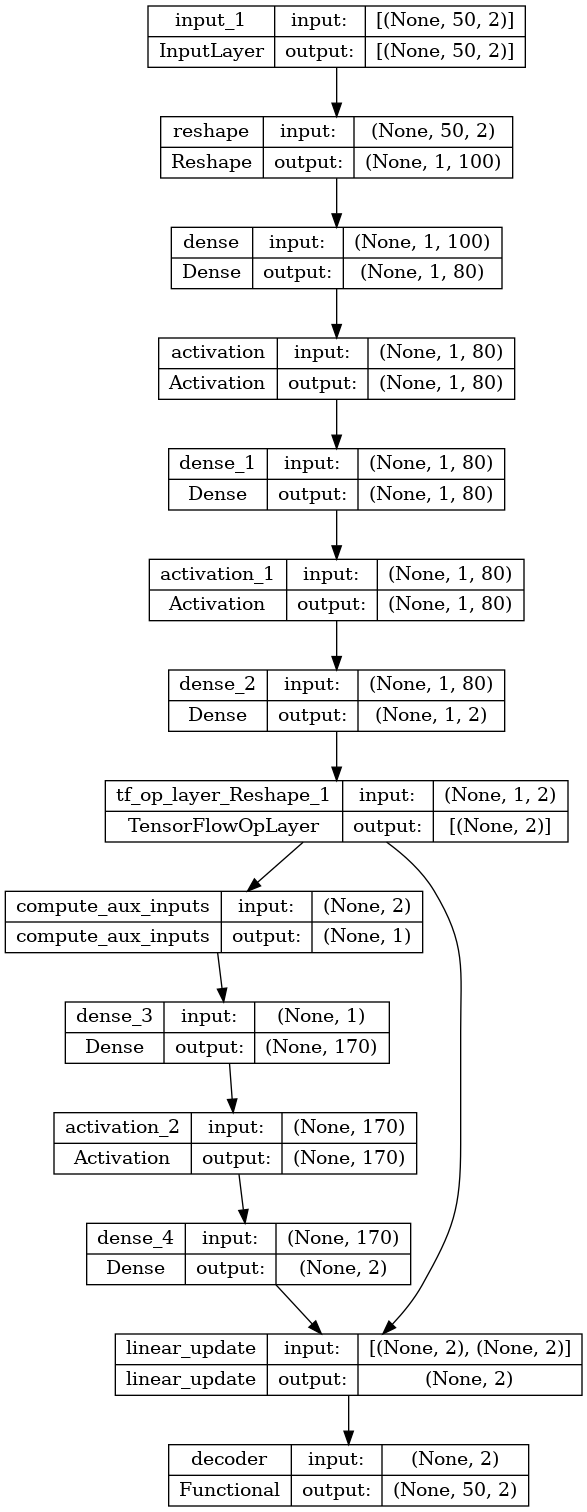

In [13]:
plot_model(full_model, show_shapes=True, show_layer_names=True)

## Train the model

In [ ]:
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = par['lr'],decay = par['lr']/par['epochs'])

full_model.compile(loss=customLoss(),
                    metrics=[State_loss, Rec_loss,Rec_plus1_loss,Linearity_loss
                            ],
                   optimizer=optimizer,
                  )

if load_into_memory:
    history = full_model.fit(x=train_input,y=train_output,epochs = EPOCHS, verbose=1,
                    validation_data=(valid_input,valid_output),
                    validation_steps=VALIDATION_STEPS,                     
                    batch_size=BATCH_SIZE,
                   )
    
else:
    history = full_model.fit(train_generator,epochs = EPOCHS, verbose=1,
                    validation_data=valid_generator,
                    validation_steps=VALIDATION_STEPS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                   )
history = history.history

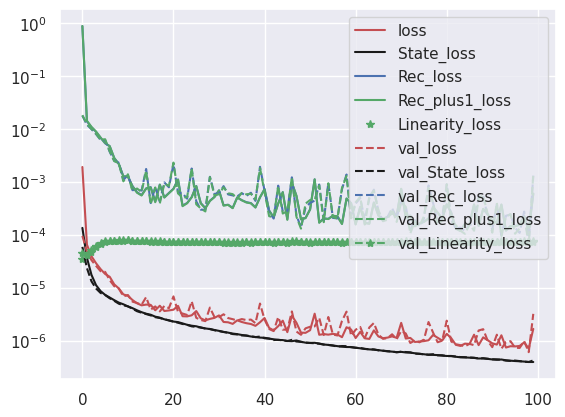

In [15]:
# training loss

plt.figure()
plt.plot((history['loss']), 'r')
plt.plot((history['State_loss']),'k')
plt.plot((history['Rec_loss']), 'b')
plt.plot((history['Rec_plus1_loss']), 'g')
plt.plot((history['Linearity_loss']), '*g')

plt.plot((history['val_loss']), '--r')
plt.plot((history['val_State_loss']),'--k')
plt.plot((history['val_Rec_loss']), '--b')
plt.plot((history['val_Rec_plus1_loss']), '--g')
plt.plot((history['val_Linearity_loss']), '*--g')


plt.legend(['loss','State_loss','Rec_loss', 'Rec_plus1_loss','Linearity_loss',
            'val_loss', 'val_State_loss','val_Rec_loss','val_Rec_plus1_loss','val_Linearity_loss'
           ])
plt.yscale('log')

# ii) Analyse the learnt dynamics model

Given this learnt model, the special components will be examined to determine if the model has captured physicaly-relevant components of the dynamical system.

## Visualise the learnt next step prediction

Examinging the next step prediction shows that the model can successfully predict future timesteps.

Text(0, 0.5, '$\\dot{\\theta}$')

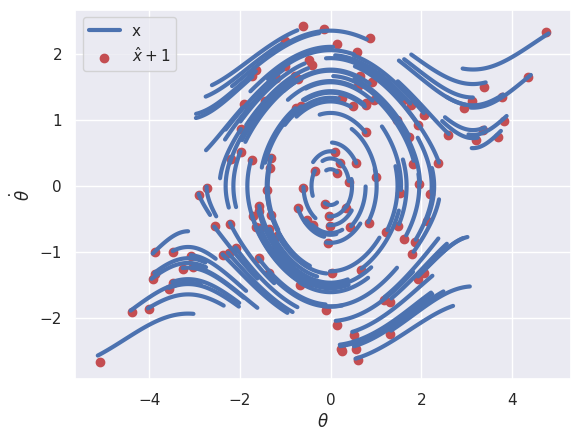

In [22]:
xhat_tp1 = full_model.predict(train_generator[0][0],verbose = 0)
fig = plt.figure()
for j,i in enumerate(range(128)):
    plt.plot(train_generator[0][0][i,:,0],train_generator[0][0][i,:,1],color='b', label = 'x' if j == 0 else "",linewidth=3)
    plt.scatter(xhat_tp1[i,-1,0],xhat_tp1[i,-1,1],color='r', label = r'$\hat{x}+1$' if j == 0 else "")
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')

# Characterising outputs

Long-term predictions can be made with this model, but key to Deep Koopman is that the model contains spectral components that characterise the actual physical behaviour. It is not good enough to make accurate predictions, these predictions needs to be explainable in the context of dynamical systems.

To explore this, the following diagram displays outputs of the learnt model, mapped onto phase space, latent space, or time series. Following the diagram, a brief explaination of each subplot is given.

In [23]:
# Load the data in the long samples into memory for easy of computation in plotting
long_data = []
filenames = ['./data/long_a.hdf5', './data/long_b.hdf5', './data/long_c.hdf5']
for filename in filenames:
    with h5py.File(filename, 'r') as f:
        long_data.append(f[list(f.keys())[0]][()][:, :, :xmax_state])
long_data_a, long_data_b, long_data_c = long_data

# Compute outputs for training data
train_data_eigenvalues, train_data_latent = Knet.predict(train_input, verbose=0)

# Compute outputs for long data
long_data_all = np.concatenate([long_data_a, long_data_b, long_data_c], axis=0)
long_data_eigenvalues, long_data_latent = Knet.predict(long_data_all, verbose=0)
long_data_a_eigenvalues = long_data_eigenvalues[:long_data_a.shape[0]]
long_data_b_eigenvalues = long_data_eigenvalues[long_data_a.shape[0]:long_data_a.shape[0]+long_data_b.shape[0]]
long_data_c_eigenvalues = long_data_eigenvalues[long_data_a.shape[0]+long_data_b.shape[0]:]
long_data_a_latent = long_data_latent[:long_data_a.shape[0]]
long_data_b_latent = long_data_latent[long_data_a.shape[0]:long_data_a.shape[0]+long_data_b.shape[0]]
long_data_c_latent = long_data_latent[long_data_a.shape[0]+long_data_b.shape[0]:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


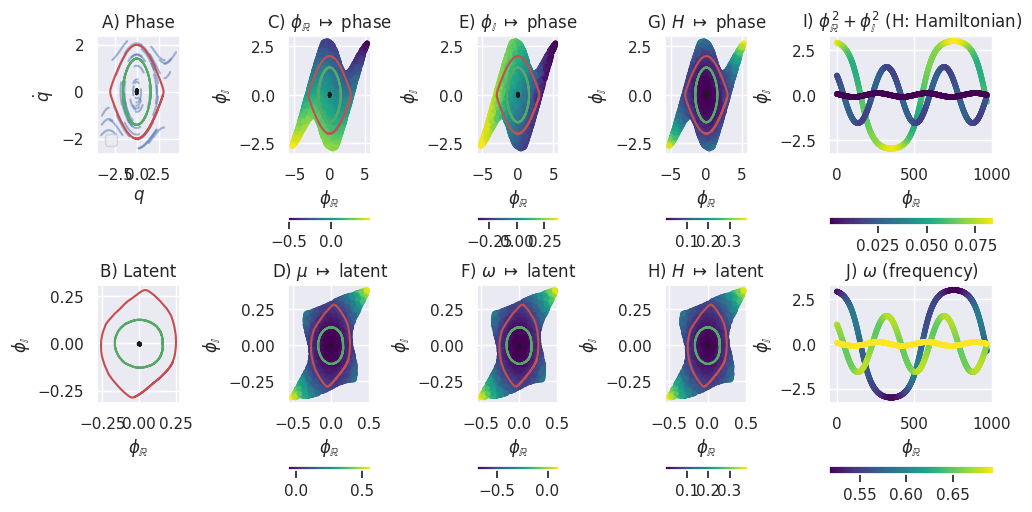

In [18]:
def make_2D_plots(eigenfunction_num_1,eigenfunction_num_2):
    # For some plots, use a smaller subset of the data
    batch, num_samples = 0, 50
    
    # Define figure
    params = {'oscilatory': {'figsize': (10, 5), 'nrows': 2, 'ncols': 6},
              'convergent': {'figsize': (9, 6), 'nrows': 2, 'ncols': 3}}
    fig = plt.figure(figsize=params[system_behaviour]['figsize'], constrained_layout=True)
    gs = GridSpec(params[system_behaviour]['nrows'], params[system_behaviour]['ncols'], figure=fig)
    # Plot the phase/latent trajectories and highlighted trajectories in subplots
    titles = ['A) Phase',
              'B) Latent',
              "C) {} $\mapsto$ phase".format(r'$\phi_\mathbb{R}$' if system_behaviour == 'oscilatory' else r'$\phi_1$'),
              "D) {} $\mapsto$ latent".format(r'$\mu$' if system_behaviour == 'oscilatory' else r'$\lambda_1$'),
              "E) {} $\mapsto$ phase".format(r'$\phi_\mathbb{I}$' if system_behaviour == 'oscilatory' else r'$\phi_2$'),
              "F) {} $\mapsto$ latent".format(r'$\omega$' if system_behaviour == 'oscilatory' else r'$\lambda_2$'),
              "G) $H$ $\mapsto$ phase",
              "H) $H$ $\mapsto$ latent",
              "I) $\phi_\mathbb{R}^2 + \phi_\mathbb{I}^2 $ (H: Hamiltonian)",
              "J) $\omega$ (frequency)"
             ]
    combinations = itertools.product(range(params[system_behaviour]['ncols']), range(params[system_behaviour]['nrows']))
    for i, (title,(column,row)) in enumerate(zip(titles,combinations)):
        if column < 4:
            ax = fig.add_subplot(gs[row, column])
        else:
            ax = fig.add_subplot(gs[row, column:])
        ax.set_title(title)
        ax.set_xlabel(r'$q$' if i == 0 else r'$\phi_\mathbb{R}$')
        ax.set_ylabel(r'$\dot{q}$' if i == 0 else r'$\phi_\mathbb{I}$')
        
        #Plot background phase trajectories for the first cell
        if row == 0 and column==0:
            for i in range(num_samples):
                ax.plot(train_input[i, :, 0], train_input[i, :, 1], 'b', alpha=0.5)
            ax.legend(ncol=1, loc='lower left')
        
        # For all columns not the time plots
        if column < 4:
            # Plot trajectories and highlighted trajectories
            for data, label, color in zip([long_data_a, long_data_b, long_data_c], 
                                       [r'$x_a$', r'$x_b$', r'$x_c$'], 
                                       ['r', 'g', 'k']) if row == 0 else zip([long_data_a_latent, long_data_b_latent, long_data_c_latent], 
                                                                               [r'$y_a$', r'$y_b$', r'$y_c$'], 
                                                                               ['r', 'g', 'k']):
                ax.plot(data[:, -1, 0] if row == 0 else data[:, eigenfunction_num_1], 
                        data[:, -1, 1] if row == 0 else data[:, eigenfunction_num_2], 
                        color=color)
            
            if column > 0:
                # Plot the scatter map with colors for each variable
                if row == 0:
                    if column == 1:
                        c = train_data_latent[:, eigenfunction_num_1]
                    elif column == 2:
                        c = train_data_latent[:, eigenfunction_num_2]
                    else:
                        c = train_data_latent[:, eigenfunction_num_1]**2 + train_data_latent[:, eigenfunction_num_2]**2
                    x, y = train_input[:, -1, :2].T
                else:
                    if column == 1:
                        c = train_data_eigenvalues[:, eigenfunction_num_1]
                    elif column == 2:
                        c = train_data_eigenvalues[:, eigenfunction_num_2]
                    else:
                        c = train_data_latent[:, eigenfunction_num_1]**2 + train_data_latent[:, eigenfunction_num_2]**2
                    x, y = train_data_latent[:, [eigenfunction_num_1, eigenfunction_num_2]].T
                sc = ax.scatter(x, y, c=c, cmap='viridis', marker='.')
                cbar = plt.colorbar(sc, orientation='horizontal')

        else:
            # Plot the time plots
            # If we're on the first row, plot energy data
            if row == 0:
                # Calculate the energy of each system using the square of the sum of two eigenfunctions
                values = np.concatenate([
                    (long_data_a_latent[:, eigenfunction_num_1]**2 + long_data_a_latent[:, eigenfunction_num_2]**2),
                    (long_data_b_latent[:, eigenfunction_num_1]**2 + long_data_b_latent[:, eigenfunction_num_2]**2),
                    (long_data_c_latent[:, eigenfunction_num_1]**2 + long_data_c_latent[:, eigenfunction_num_2]**2)
                ])
                # Set the color range for the scatter plot based on the minimum and maximum energy values
                vmin, vmax = np.min(values), np.max(values)
                # Define the data and latent lists based on the order of the systems
                data_list = [long_data_a, long_data_b, long_data_c]
                latent_list = [long_data_a_latent, long_data_b_latent, long_data_c_latent]

            # If we're on the second row, plot frequency data
            elif row == 1:
                # Calculate the frequency of each system using the absolute value of the second eigenvalue
                values = np.concatenate([
                    long_data_a_eigenvalues[:, eigenfunction_num_2],
                    long_data_b_eigenvalues[:, eigenfunction_num_2],
                    long_data_c_eigenvalues[:, eigenfunction_num_2]
                ])
                # Set the color range for the scatter plot based on the minimum and maximum frequency values
                vmin, vmax = np.min(np.abs(values)), np.max(np.abs(values))
                # Define the data and latent lists based on the order of the systems, but with the eigenvalues instead of eigenvectors
                data_list = [long_data_a, long_data_b, long_data_c]
                latent_list = [long_data_a_eigenvalues, long_data_b_eigenvalues, long_data_c_eigenvalues]
                
            # Loop through each system's data and corresponding latent values
            for data, latent in zip(data_list, latent_list):
                ax.scatter(range(data.shape[0]), data[:,-1,0],
                           c=latent[:,eigenfunction_num_1]**2+latent[:,eigenfunction_num_2]**2 if row==0 else np.abs(latent[:,eigenfunction_num_2]),
                           vmin=vmin, vmax=vmax,
                           marker='.', cmap='viridis')
            sc = ax.collections[-1]  # get the last scatter plot
            cbar = plt.colorbar(sc, orientation='horizontal')


make_2D_plots(0,1)   

## Analysis:

Please see the following paper for a more detailed analysis of this problem:

[^fn0]: Komeno, Naoto, Brendan Michael, Katharina Küchler, Edgar Anarossi, and Takamitsu Matsubara. "Deep Koopman with Control: Spectral Analysis of Soft Robot Dynamics." 2022 61st Annual Conference of the Society of Instrument and Control Engineers (SICE). IEEE, 2022. https://ieeexplore.ieee.org/abstract/document/9905758/
[^fn00]: https://arxiv.org/pdf/2210.07563.pdf

## Explainations:

A) State (phase) space of the problem. Three exemplar trajectories are presented:
- xa): Small initial angle. This is approximately 6 degrees, and as such the dynamics are approximately linear (small angle approximation)
- xb): Medium initial angle.
- xc): Large initial angle

B) Latent space. Trajectories in the phase space are mapped via a single complex conjugate pair of learnt eigenfunctions (C and D), to a latent-space that is linear in polar coordinates, the system is therefore globally linearised within the Koopman framework.

E) Growths/decays of the eigenvalues are small (-0.0025 to 0.0025). This is to be expected, as this system does not experience growth.

F) Frequency of the eigenvalues varies across the latent space. As such, by using the auxiliary network inside the Koopman network to parameterise the learnt dynamics by a continuous spectra of eigenvalues, a continuous range of oscillatory frequencies is also captured by the model. This is seen in H), where the continuous spectra captures an intuitive physical characteristic of the pendulum, that being the frequency of oscillation is dependent on the position in the phase space (eigenvalue frequency decreases the further from the centre, i.e., the period of the swing increases the further from the stable equilibrium position. In the context of the pendulum, this expressed as a high frequency oscillation at small angles, and low frequency oscillation at higher angles

## Visualising linearity

The primary focus of learning a Deep Koopman architecture, is to learn a linearisation of the latent space. This following section examines the linearness of both the input phase space, and the learnt latent dynamics.

First, a measure of the linearness is given. The linearness of the input space is computed by taking the deviation of the Jacobian of the linear region, against the known state-equations. This is a measure of how well the motion of the system can be approximated by a linear system. Specifically, this code takes the Jacobian of the region of the phase space where the dynamics are linear (i.e. small angle approximation), and takes the difference between that and the actual non-linear dynamics of the pendulum (i.e. [qdot,-g/l*sin*(q)]). This value then allows us to see which regions are linear. This is refered to as the Jacobian of the phase space, even though it is only for the linear region.

The second function examines how much the Jacobian of the learnt (hopefully linear) space deviates from the identity matrix, as such, how much the latent data changes when transformed by the Jacobian. This gives a measure of how linear the latent space is.

In [19]:
def compute_linearness(X):
    # Assume the system is parameterised as follows:
    g = 1
    L = 1.0
    
    # Extract q and qdot from X
    q = X[:, :, 0]
    qdot = X[:, :, 1]
    
    # Compute the Jacobian of the system at each time step for each sample
    jacobians = np.zeros((X.shape[0], X.shape[1], X.shape[2], X.shape[2]))
    jacobians[:, :, 0, 1] = 1
    jacobians[:, :, 1, 0] = -g/L * np.cos(q)
    
    # Compute the deviation from linearity for each sample
    squared_deviation = np.square(np.einsum('ijk,ik->ij', jacobians.reshape(-1, 2, 2), X.reshape(-1, X.shape[2])) - np.array([qdot.flatten(), -g/L*np.sin(q).flatten()]).T)
    rms_deviation = np.sqrt(np.mean(squared_deviation, axis=1))
    rms_deviation = rms_deviation.reshape(X.shape[:2])
    squared_deviation = squared_deviation.reshape(X.shape)
    return squared_deviation, jacobians, rms_deviation

def compute_latent_linearness(latent_data):
    # Compute the Jacobian of the linear dynamics at each time step for each sample
    jacobians = jacobian_model.predict(latent_data)
    # Compute the deviation from linearity for each sample
    squared_deviation = np.square(np.einsum('ijk,ik->ij', jacobians, latent_data) - latent_data)
    rms_deviation = np.sqrt(np.mean(squared_deviation, axis=1))
    return squared_deviation, jacobians, rms_deviation

Given these functions, the below plot examines the linearity and stability of the systems:
    
A) In this, we can see that the central region of the phase space can be seen as the region where the linear approximation is a good approximation of the true dynamics (due to the small angle approximation). As we move further to the outer reaches, non-linearities become more prevalent.

B) A similar plot is show where the latent linearity score is mapped onto the phase space, and we can see that higher angles are now captured within a linear dynamical system.

C,D) To better understand the dynamics, a plot spectral radius of the Jacobian (the stability of the eigenvalues) is plotted against deviation from linearity score. 



1. Points with low RMS-scores and low spectral radii are regions where the linear approximation holds well, and the system is stable (i.e., small perturbations will not cause the system to diverge).

2. Points with high RMS-scores and low spectral radii are regions where the linear approximation is poor, but the system is still stable.

3. Points with low RMS-scores and high spectral radii are regions where the linear approximation holds well, but the system is unstable (i.e., small perturbations will cause the system to diverge).

4. Points with high RMS-scores and high spectral radii are regions where both the linear approximation is poor, and the system is unstable.


In C), it is seen that for the phase space the system is unstable (as is expected) and decays (as the spectral radius <1), while in D) linearisation stabilises. Note also that the eigenvalues start to become less stable the further away from the centre of the phase space (zero angle and velocity), indicating that the model does not fully linearise across the entire space.

E,F) From this, we can see that different regions of the phase space can be characterised into groups, suggesting there are different types of linear dynamics in learned latent space. Each group of eigenvalues corresponds to a different set of linear dynamics that are locally stable. From D and F), we can see that the eigenvalues in this group are centered around the point (1,1) in the real/imag plane. This suggests that the linear dynamics in this group are close to the identity transformation, which means that the latent space is locally linear and stable around this point. This is a desirable property for the learned latent space, as it suggests that the dynamics in this region are well-behaved and easy to analyze.

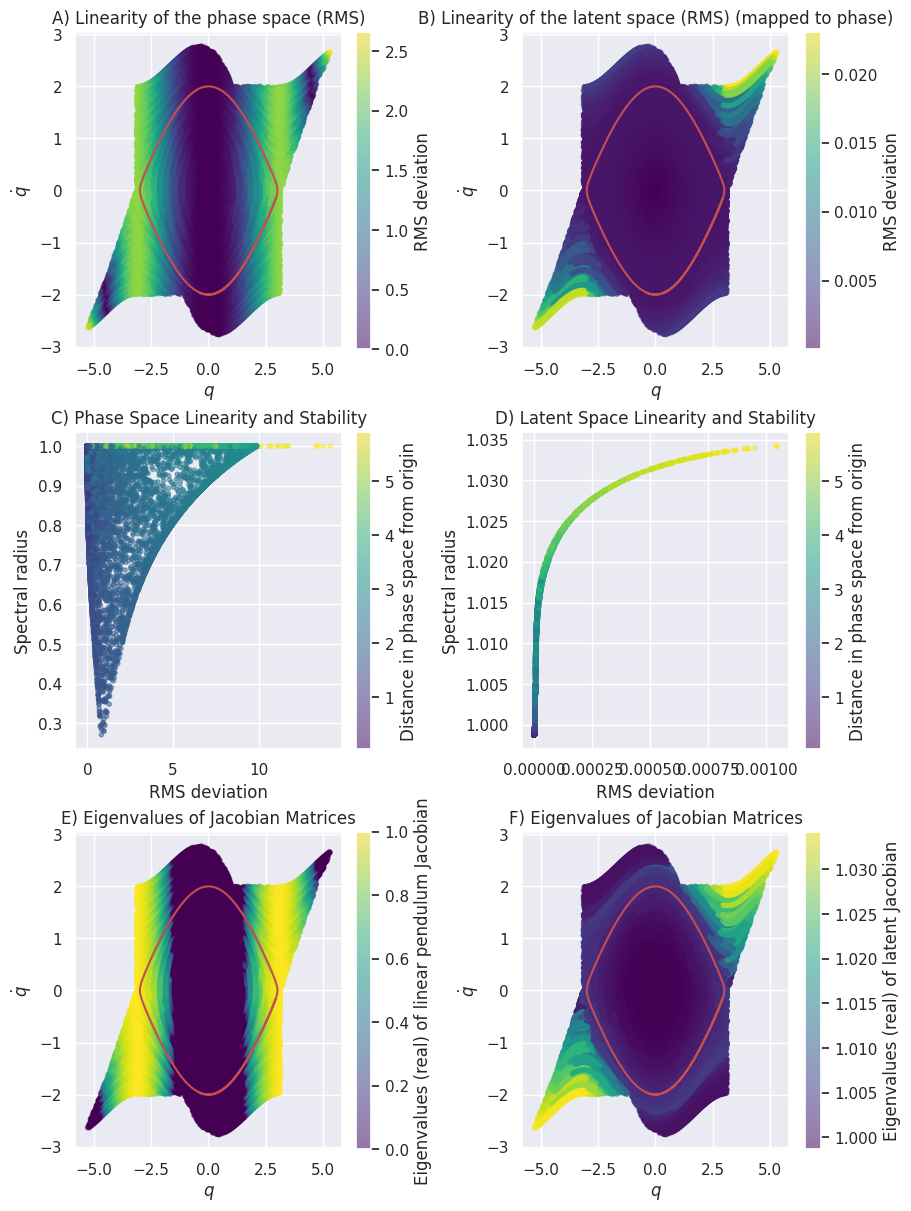

In [24]:
# Compute the Jacobians and a linearness measure
phase_space_normalized_deviations, phase_space_jacobians, phase_space_linearness = compute_linearness(train_input)
latent_space_normalized_deviations,latent_space_jacobians,latent_space_linearness = compute_latent_linearness(train_data_latent)

# compute the distance of the state to (0,0), and use this as the color for the corresponding eigenvalue
distances = np.sqrt(np.sum(train_input[:,-1,:]**2, axis=1))

# Compute the eigenvalues and spectral radii of the Jacobian matrices for the phase space and latent space
phase_eigenvalues_list = np.array([np.linalg.eig(jacobian)[0] for jacobian in phase_space_jacobians])
phase_spectral_radii = np.array([np.max(np.abs(eigenvalues)) for eigenvalues in phase_eigenvalues_list])
latent_eigenvalues_list = np.array([np.linalg.eig(jacobian)[0] for jacobian in latent_space_jacobians])
latent_spectral_radii = np.array([np.max(np.abs(eigenvalues)) for eigenvalues in latent_eigenvalues_list])

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 12), constrained_layout=True)
gs = axs[0,0].get_gridspec()

# Define the titles and labels for each subplot
titles = ['A) Linearity of the phase space (RMS)', 'B) Linearity of the latent space (RMS) (mapped to phase)',
          'C) Phase Space Linearity and Stability', 'D) Latent Space Linearity and Stability',
          'E) Eigenvalues of Jacobian Matrices', 'F) Eigenvalues of Jacobian Matrices']
labels = ['RMS deviation', 'RMS deviation', 'Distance in phase space from origin', 'Distance in phase space from origin',
          'Eigenvalues (real) of linear pendulum Jacobian', 'Eigenvalues (real) of latent Jacobian']

# Define the data to be plotted for each subplot, as well as the color value to be used for the scatter plots
scatter_args = [(train_input[:,:, 0], train_input[:,:, 1], phase_space_linearness),
                (train_input[:,:, 0], train_input[:,:, 1], np.tile(latent_space_linearness,(DATA_TIMESTEPS,1)).T),
                (np.linalg.norm(phase_space_normalized_deviations[:,-1,:],axis=1), phase_spectral_radii, distances),
                (np.linalg.norm(latent_space_normalized_deviations,axis=1), latent_spectral_radii, distances),
                (train_input[:,:, 0],train_input[:,:, 1], phase_eigenvalues_list[:,:,0]),
                (train_input[:,:, 0], train_input[:,:, 1], np.tile(latent_eigenvalues_list[:,0],(DATA_TIMESTEPS,1)).T)]

# Iterate over the subplots and their corresponding data
for ax, title, label, scatter_arg in zip(axs.flatten(), titles, labels, scatter_args):
    # Scatter the data for each plot
    sc = ax.scatter(scatter_arg[0],scatter_arg[1],c=scatter_arg[2], marker='.',cmap = 'viridis', alpha=0.5)
    cbar = plt.colorbar(sc, label = label, orientation='vertical')
    
    # For subplots with titles containing 'A)', 'B)', 'E)', or 'F)', overlay a red line plot showing the trajectory of the system
    if any(option in title for option in ('A)', 'B)','E)','F)')):
        ax.plot(long_data_a[:,-1,0],long_data_a[:,-1,1],'r')
        ax.set_xlabel(r'$q$')
        ax.set_ylabel(r'$\dot{q}$')
    
    # For subplots with titles containing 'Stability', set the x and y axis labels to 'RMS deviation' and 'Spectral radius', respectively
    if 'Stability' in title:
        ax.set_xlabel('RMS deviation')
        ax.set_ylabel('Spectral radius')        
    
    ax.set_title(title)

# Other interesting pendulum dynamics


## Control

This notebook also works for systems under control (see  https://arxiv.org/pdf/2210.07563.pdf).

To experiment with this, please change the control signal option in 'Generate pendulum data.ipynb' to 'pd' and change N = 300, and set 'num_control=1' in this notebook.


![image info](./figs/pendulum_pd_controller.png)